In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
df = pd.read_csv('HIGGS_smaller.csv')

df_sample = df.sample(frac=0.3, random_state=42)

y = df_sample.iloc[:,0].to_numpy()
X = df_sample.iloc[:,1:].to_numpy()

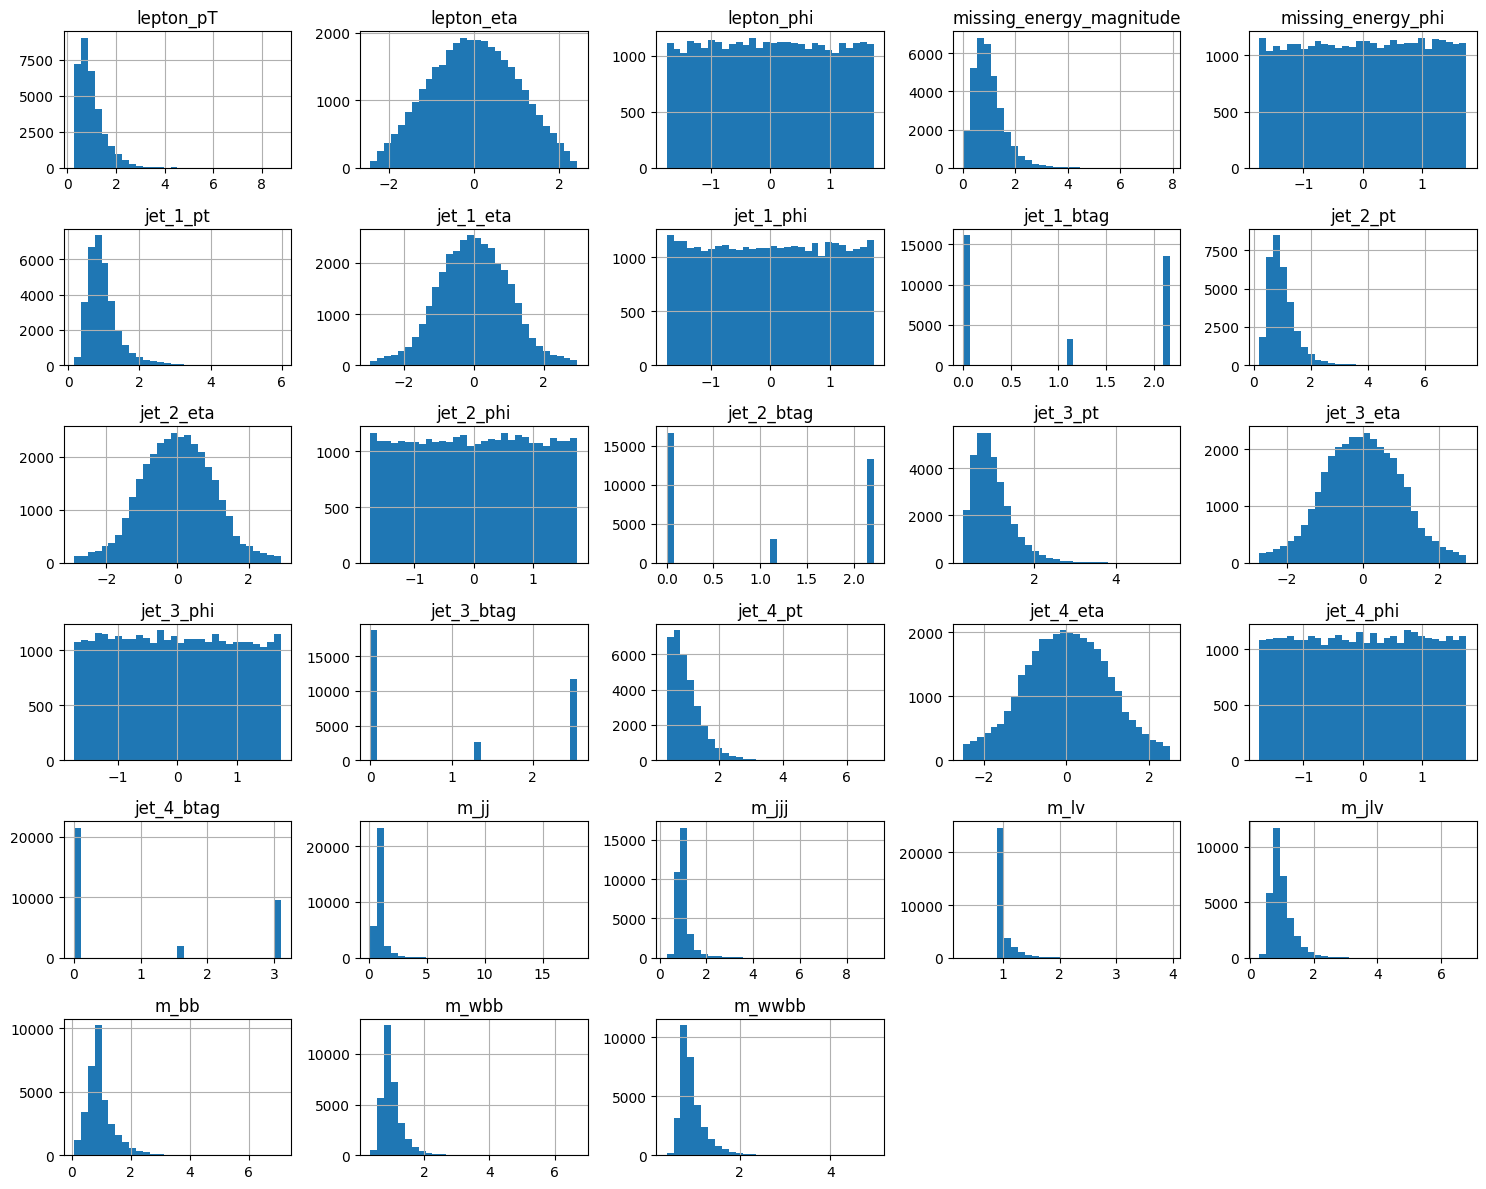

In [117]:
def add_column_names(X):
    column_names = [
        'lepton_pT', 'lepton_eta', 'lepton_phi', 'missing_energy_magnitude', 'missing_energy_phi',
        'jet_1_pt', 'jet_1_eta', 'jet_1_phi', 'jet_1_btag',
        'jet_2_pt', 'jet_2_eta', 'jet_2_phi', 'jet_2_btag',
        'jet_3_pt', 'jet_3_eta', 'jet_3_phi', 'jet_3_btag',
        'jet_4_pt', 'jet_4_eta', 'jet_4_phi', 'jet_4_btag',
        'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb'
    ]
    
    # Create a DataFrame and assign the column names
    X_df = pd.DataFrame(X, columns=column_names)
    return X_df

# Example usage
X_df = add_column_names(X)

# Now you can visualize histograms with column names attached
X_df.hist(figsize=(15, 12), bins=30)
plt.tight_layout()
plt.show()


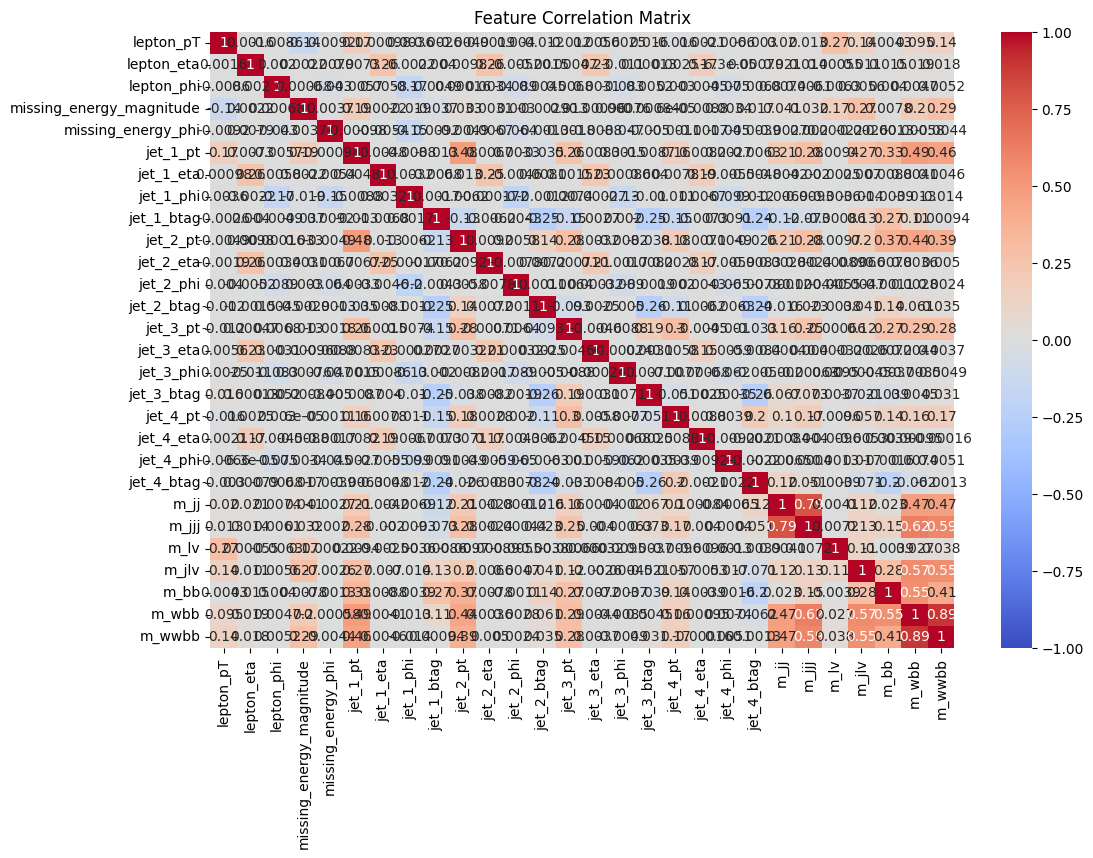

In [118]:
# Compute correlation matrix
corr_matrix = X_df.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()


In [119]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = X_df.copy()

for column in X_scaled.columns:
    if X_scaled[column].min() > 0:
        X_scaled[column] = X_scaled[column] / X_scaled[column].mean()
    else:
        X_scaled[column] = scaler.fit_transform(X_scaled[column].values.reshape(-1, 1))

X_df = X_scaled.copy()

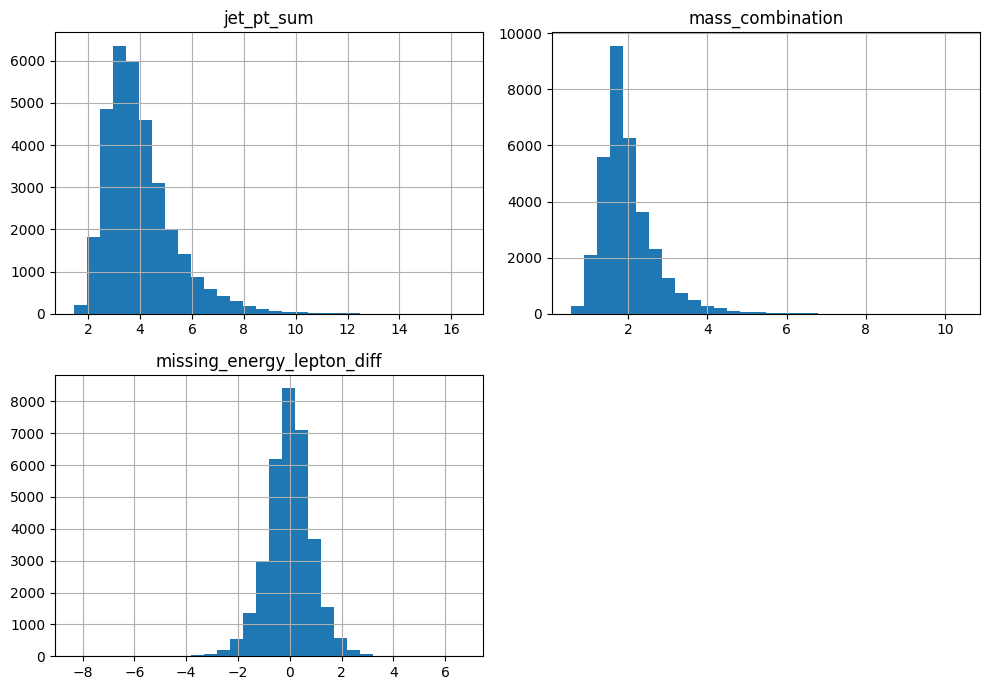

In [120]:
# Create new features based on domain knowledge
X_df['jet_pt_sum'] = X_df['jet_1_pt'] + X_df['jet_2_pt'] + X_df['jet_3_pt'] + X_df['jet_4_pt']
X_df['mass_combination'] = X_df['m_bb'] + X_df['m_wwbb']  # Combine masses of interest
X_df['missing_energy_lepton_diff'] = X_df['missing_energy_magnitude'] - X_df['lepton_pT']  # Example difference

# Now visualize the distribution of these new features
X_df[['jet_pt_sum', 'mass_combination', 'missing_energy_lepton_diff']].hist(figsize=(10, 7), bins=30)
plt.tight_layout()
plt.show()

In [121]:
X_df.head()

,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_btag,jet_2_pt,...,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,jet_pt_sum,mass_combination,missing_energy_lepton_diff
0,1.320408,-0.838760,-1.196344,1.843976,-1.660393,1.199386,-1.034889,0.388094,1.140373,0.554140,...,0.373698,1.314994,0.930242,1.565137,1.110387,1.551195,1.742460,3.730706,2.852847,0.523569
1,1.193960,-0.292211,-1.109562,1.521271,1.676562,2.097376,2.237881,0.005247,-0.975465,2.375828,...,1.745887,1.017738,1.004671,1.160183,0.499215,0.913947,0.899348,6.293471,1.398563,0.327311
2,0.489361,0.597744,-0.164906,0.959078,1.470209,0.609733,1.114276,1.408748,-0.975465,0.638339,...,1.510464,0.959095,0.940103,0.821970,0.268938,0.666407,0.696804,2.455831,0.965742,0.469716
3,1.955414,1.271982,0.300613,1.602092,1.372024,0.448440,1.438807,-0.673732,1.140373,0.575190,...,0.710427,0.750333,1.929110,1.203965,0.770965,0.817759,0.840352,2.814390,1.611317,-0.353322
4,2.085554,0.475859,-0.011241,1.330374,-0.269554,3.108632,0.768174,-1.599659,1.140373,1.587605,...,1.894236,1.172883,0.928989,2.567211,2.553204,1.761001,1.684217,6.753023,4.237421,-0.755180


In [122]:
X_df_dropped = X_df.drop(columns=['jet_1_pt', 'jet_2_pt', 'jet_3_pt', 'jet_4_pt', 'm_bb', 'm_wwbb', 'missing_energy_magnitude', 'lepton_pT'])

X_df = X_df_dropped

X_df.shape

(33000, 23)

In [123]:
from sklearn.decomposition import PCA

# # Apply PCA to reduce dimensionality
pca = PCA(n_components=10)  # Choose number of components
X_pca = pca.fit_transform(X_df)

# check percentage of variance explained by each of the selected and all components
# explained_variance_ratio = pca.explained_variance_ratio_
# print(explained_variance_ratio)

In [124]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

print(X_train.shape)

(26400, 23)


In [126]:
# SVM with Linear Kernel
svm_model = SVC(kernel='linear', probability=True)

In [127]:
# Perform cross-validation to evaluate the SVM model
from sklearn.model_selection import StratifiedShuffleSplit

stratified_split = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
cross_val_scores = cross_val_score(svm_model, X_train, y_train, cv=stratified_split, n_jobs=-1)
print(f'Cross-Validation Accuracy: {np.mean(cross_val_scores):.2f} ± {np.std(cross_val_scores):.2f}')

Cross-Validation Accuracy: 0.62 ± 0.00


In [128]:
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)
y_prob = svm_model.predict_proba(X_test)[:, 1]  

# Calculate classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Report metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'AUC: {roc_auc:.2f}')

Accuracy: 0.63
Precision: 0.61
Recall: 0.83
F1 Score: 0.70
AUC: 0.66
